# Comparing Genefromer & UCE

It is not always easy working with different bio foundation models...

In the example notebook, we levarge Helical to compare two leading RNA foundation models: Geneformer and UCE. It also serves a template on to use those models in a standardised way in your own applications.

### Geneformer
Geneformer is a foundation transformer model pretrained on Genecorpus-30M, a corpus comprised of ~30 million single cell transcriptomes from a broad range of human tissues. Each single cell’s transcriptome is presented to the model as a rank value encoding where genes are ranked by their expression in that cell normalized by their expression across the entire Genecorpus-30M. Geneformer displays both zero-shot capabilities as well as fine-tuning tasks relevant to chromatin and network dynamics.
- 📄 [Paper](https://www.nature.com/articles/s41586-023-06139-9): The paper that made it into Nature!
- 💽 [GitHub]XXX

### UCE
The Universal Cell Embedding (UCE) model creates a universal biological representation space for cells, leveraging a self-supervised learning approach on cell atlas data from diverse species (which is a key differentiator from geneformer, trained on human data). UCE creates an atlas of over 36 million cells, with more than 1,000 uniquely named cell types, from hundreds of experiments, dozens of tissues and eight species. It captures significant biological variations and enables mapping of any cell to this embedding without further model adjustments.
- 📄 [Paper](https://www.biorxiv.org/content/10.1101/2023.11.28.568918v1)
- 💽 [GitHub](https://github.com/snap-stanford/UCE)


### 🧬 About Helical:
Helical provides an open-source framework for and gathers state-of-the-art pre-trained genomics and transciptomics bio foundation models. Still work in progress, but we look forward to interacting with the community to build meaningful things. You can directly reach us:
- in the channel #xxx in the BiB community
- [Github](https://github.com/helicalAI/helical-package/issues). On our github in the issue section 


### Before you start
Be sure to install the Helical python package as well as cloning it as described in [Installation](https://github.com/helicalAI/helical-package) & [Demo & Use Cases](https://github.com/helicalAI/helical-package) in the ReadMe file of our github.

## 1) Imports 
Let's start by importing all the packages used in this notebook

In [25]:
import anndata as ad
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd
import logging
import requests


logging.getLogger().setLevel(logging.WARNING)

warnings.filterwarnings("ignore")

# Import Geneformer & UCE from the Helical package
from helical.models.geneformer.model import Geneformer,GeneformerConfig
from helical.models.uce.model import UCE,UCEConfig

## 2) Dataset loading and Splitting
The dataset leveraged has to be downloded as described above in "Before getting started".

The data set is a subset of the human PBMC, comprising 54,760 training cells and 13,690 test cells, with 16,906 genes across 11 distinct cell types. It is great for benchmarking due to its class imbalance.
Data available (it has already been downloaded for you, but in case you want to access it seperately): https://www.ebi.ac.uk/ena/browser/view/PRJNA318252

Let's start by running the command below to download the data set automatically (this could take a few seconds):

In [36]:
url = "https://helicalpublicdata.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"Files already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

Files already exist. Skipping downloads.


In [31]:
ann_data = ad.read_h5ad("10k_pbmcs_proc.h5ad")
#Split the data set into a training and test set to evluate results down-the-line.
X_train, X_test = train_test_split(ann_data,train_size=0.01,test_size=0.005,random_state=0)

## 3) Zero Shot prediction with Geneformer

### Model training and inference

The first time you execute the cell below, the model weights will be downloaded automatically, this could take a few seconds:

In [30]:
model_config = GeneformerConfig(batch_size=5)   
geneformer = Geneformer(model_config=model_config)

In [33]:
# The "process_data"-function from the Helical package pre-processes the data. 
# It takes AnnData as an input. 
# More information in our documentation
train_dataset = geneformer.process_data(X_train)
test_dataset = geneformer.process_data(X_test)

Creating dataset.


Map (num_proc=4):   0%|          | 0/119 [00:00<?, ? examples/s]

Creating dataset.


Map (num_proc=4):   0%|          | 0/60 [00:00<?, ? examples/s]

In [34]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

### Visualization with UMAP

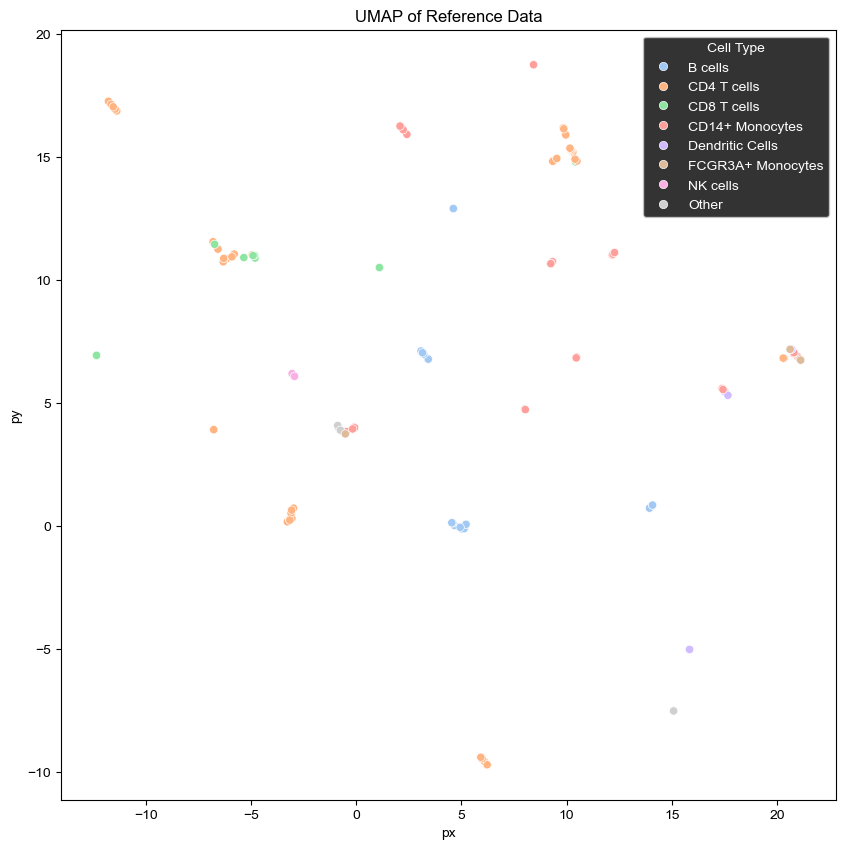

In [35]:
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()

### Evaluation: k-nearest neighbors

We use a K-Neirhbours classifier to find the cells which are the most similar to our test data.

In [37]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [38]:
pred_labels = neigh.predict(test_embeddings)

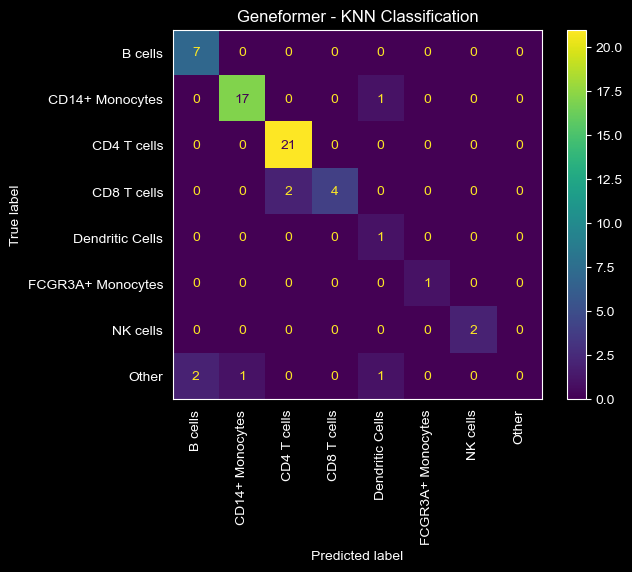

In [39]:
cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

In [40]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       0.78      1.00      0.88         7
  CD14+ Monocytes       0.94      0.94      0.94        18
      CD4 T cells       0.91      1.00      0.95        21
      CD8 T cells       1.00      0.67      0.80         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.88        60
        macro avg       0.75      0.83      0.76        60
     weighted avg       0.85      0.88      0.86        60



## 4) Zero Shot prediction with UCE

### Model training and inference

In [ ]:
model_config = UCEConfig(batch_size=5)
uce = UCE(model_config=model_config)

[==========================================        ]

In [ ]:
train_data = uce.process_data(X_train)
ref_embeddings = uce.get_embeddings(train_data)

### Visualization with UMAP

In [ ]:
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()

### Evaluation: k-nearest neighbors

In [ ]:
test_data = uce.process_data(X_test, data_config_path="./data/config.json")
test_embeddings = uce.get_embeddings(test_data)

In [ ]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

pred_labels = neigh.predict(test_embeddings)

In [ ]:
cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("UCE - KNN Classification")
plt.show()

In [ ]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

## 5) Compare Results 
Now that we have looked at each of the models individually, let's compare the results to see how they perform side by side

## What's next ?
Stay tuned, we will add the most relevant RNA foundation models to Helical and release a benchmarking script that will allow you to benchmark RNA models on your data for fast assessment of which model is the most powerful for your task at hand.

Join our slack channel and like our github repo to stay up-to-date!